In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score,f1_score
import random
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')
# pwd path to data folders
PWD = '/content/drive/My Drive/ML/Fashies/data/'
#read the data
train_data = pd.read_csv(PWD+'train.csv',sep=';')
blind_data  = pd.read_csv(PWD+'leaderboard_test_features.csv',sep=';')


Mounted at /content/drive


In [33]:
#read the data
#train_data = pd.read_csv('force2020_train.csv',sep=';')
blind_data  = pd.read_csv('force2020_leaderboard_test_features.csv',sep=';')

In [34]:
# print data dim
print (f"Train data contain {train_data['WELL'].unique().shape[0]} wells.")
print (f"Train data observations {blind_data.shape[0]}.")

Train data contain 98 wells.
Train data observations 136786.


In [4]:
print (train_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1170511 entries, 0 to 1170510
Data columns (total 29 columns):
 #   Column                             Non-Null Count    Dtype  
---  ------                             --------------    -----  
 0   WELL                               1170511 non-null  object 
 1   DEPTH_MD                           1170511 non-null  float64
 2   X_LOC                              1159736 non-null  float64
 3   Y_LOC                              1159736 non-null  float64
 4   Z_LOC                              1159736 non-null  float64
 5   GROUP                              1169233 non-null  object 
 6   FORMATION                          1033517 non-null  object 
 7   CALI                               1082634 non-null  float64
 8   RSHA                               630650 non-null   float64
 9   RMED                               1131518 non-null  float64
 10  RDEP                               1159496 non-null  float64
 11  RHOB                    

In [5]:
#three categorical logs, count them
print ('Wells:',train_data['WELL'].value_counts().shape[0])
print ('Group:',train_data['GROUP'].value_counts().shape[0])
print ('FORMATION:',train_data['FORMATION'].value_counts().shape[0])

Wells: 98
Group: 14
FORMATION: 69


/var/folders/xc/cnszhbxs6hn4qsj_h5yt3k7c0000gn/T/ipykernel_2904/776348186.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(train_data.columns[2:-2],rotation=45)


Text(0, 0.5, 'Well presence (\\%)')

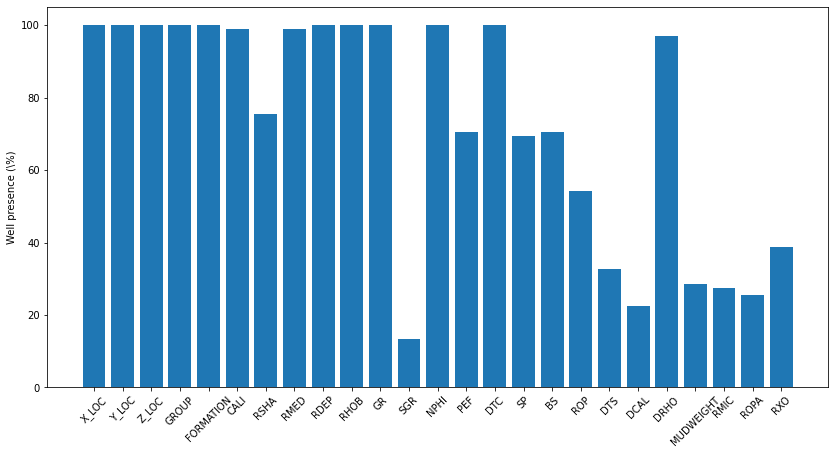

In [6]:
# occerences of each logs in all 98 wells
# check logs and find percentage of logs in wells
occurences = np.zeros(25) # 25 logs exluding wells, FORCE litho colums 
for well in train_data['WELL'].unique():
    occurences += train_data[train_data['WELL']==well].isna().all().astype(int).values[2:-2] 
    # took columns with missing
fig,ax = plt.subplots(1,1,figsize=(14,7))
ax.bar(x=np.arange(occurences.shape[0]), height = (train_data.WELL.unique().shape[0]-occurences)/\
       train_data.WELL.unique().shape[0]*100.0)
ax.set_xticklabels(train_data.columns[2:-2],rotation=45)
ax.set_xticks(np.arange(occurences.shape[0]))
ax.set_ylabel('Well presence (\%)')
# some logs are complete, some presented just 30%

In [35]:
# find nan values, sum along columns, devide N_obs
# drop lods with 100 %
train_logs = dict(100 - blind_data.isna().sum()/blind_data.shape[0] * 100)
train_logs = {log:value for log,value in train_logs.items() if value!=100}
train_logs
# same as looking at graphical percentage but by numbers
#plt.figure(figsize=(14,7))
#plt.bar(train_logs.keys(),train_logs.values())
#plt.xticks(list(train_logs.keys()),rotation=45)
#plt.tight_layout()

{'X_LOC': 99.95686693082625,
 'Y_LOC': 99.95686693082625,
 'Z_LOC': 99.95686693082625,
 'FORMATION': 94.82841811296478,
 'CALI': 95.87311566973229,
 'RSHA': 28.58260348281256,
 'RMED': 99.57086251516968,
 'RDEP': 99.95686693082625,
 'RHOB': 87.60107028497069,
 'SGR': 0.0,
 'NPHI': 76.06260874650914,
 'PEF': 82.97852119368942,
 'DTC': 99.3983302384747,
 'SP': 48.70893220066381,
 'BS': 48.9553024432325,
 'ROP': 49.94370768938342,
 'DTS': 31.596800842191456,
 'DCAL': 9.880397116663985,
 'DRHO': 81.5551299109558,
 'MUDWEIGHT': 14.818036933604319,
 'RMIC': 8.272776453730643,
 'ROPA': 40.78633778310646,
 'RXO': 21.820946588101123}

In [11]:
# lets explore labels, targets 
labels = dict(train_data.FORCE_2020_LITHOFACIES_LITHOLOGY.value_counts())
litho_names= ['Shale','Sandstone','SS/Shale','Marl','Dolomite','Limestone','Chalk', 'Halite','Anhydrite','Tuff','Coal','Basement']

lithology_keys = {30000: 'Sandstone',65030: 'Sandstone/Shale',65000: 'Shale',80000: 'Marl',
                 74000: 'Dolomite',70000: 'Limestone',70032: 'Chalk',88000: 'Halite',86000: 'Anhydrite',
                 99000: 'Tuff', 90000: 'Coal', 93000: 'Basement'}
lithologies = {30000: 0,65030: 1,65000: 2,80000: 3, 74000: 4,70000: 5,70032: 6,88000: 7,
                  86000: 8, 99000: 9, 90000: 10, 93000: 11}

train_data['FaciesLabels'] = train_data['FORCE_2020_LITHOFACIES_LITHOLOGY'].map(lithology_keys)
train_data['Facies'] = train_data['FORCE_2020_LITHOFACIES_LITHOLOGY'].map(lithologies)
train_data.head(3)

,WELL,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,GROUP,FORMATION,CALI,RSHA,RMED,...,DCAL,DRHO,MUDWEIGHT,RMIC,ROPA,RXO,FORCE_2020_LITHOFACIES_LITHOLOGY,FORCE_2020_LITHOFACIES_CONFIDENCE,FaciesLabels,Facies
0,15/9-13,494.528,437641.96875,6470972.5,-469.501831,NORDLAND GP.,NaN,19.480835,NaN,1.611410,...,NaN,-0.574928,NaN,NaN,NaN,NaN,65000,1.0,Shale,2
1,15/9-13,494.680,437641.96875,6470972.5,-469.653809,NORDLAND GP.,NaN,19.468800,NaN,1.618070,...,NaN,-0.570188,NaN,NaN,NaN,NaN,65000,1.0,Shale,2
2,15/9-13,494.832,437641.96875,6470972.5,-469.805786,NORDLAND GP.,NaN,19.468800,NaN,1.626459,...,NaN,-0.574245,NaN,NaN,NaN,NaN,65000,1.0,Shale,2


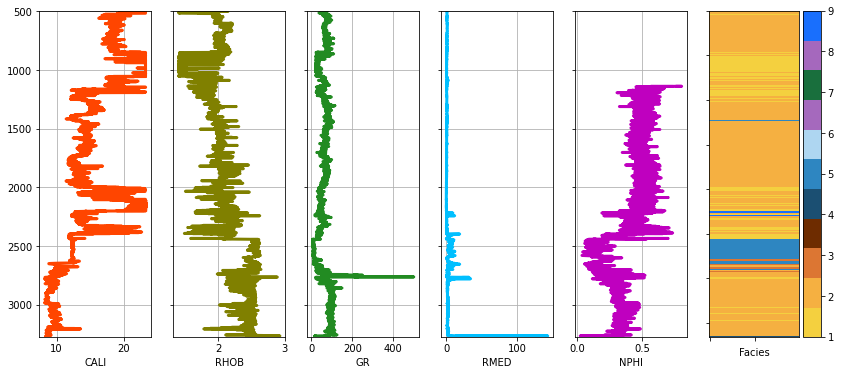

In [38]:
logs = train_data[train_data['WELL']=='15/9-13']
logs  = logs[['DEPTH_MD','Facies','CALI','RHOB','GR','RMED','NPHI']]
facies_colors = ['#F4D03F', '#F5B041','#DC7633','#6E2C00',
                 '#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D','#A568BD', '#196FFD']
plot_logs(logs,['DEPTH_MD','Facies','CALI','RHOB','GR','RMED','NPHI'],facies_colors)

<BarContainer object of 12 artists>

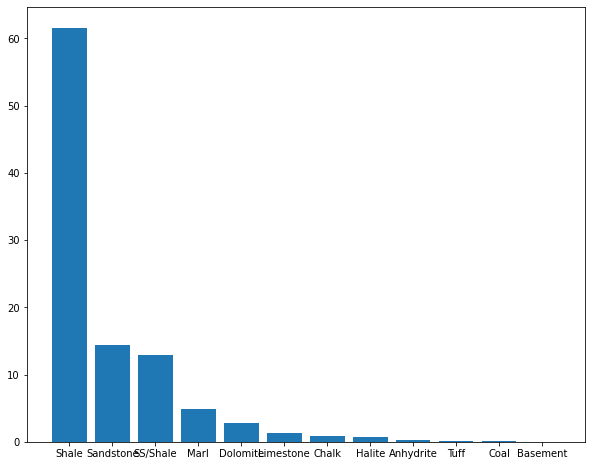

In [13]:
lithofacies_perc = np.array(list(labels.values()))/train_data.shape[0]*100
fig = plt.figure(figsize=(10,8))
plt.bar(litho_names,lithofacies_perc)
# shale class dominated, imbalanced skewed, if the blind test not inbalanced like train data(shale 60%) 
#we will get overfit because we learn from imbalaned dataset

In [14]:
# data locations, check that test and train spaitailly even distributed
#fig = plt.figure(figsize=(12,8))
#plt.scatter(train_data.X_LOC,train_data.Y_LOC,c='g')
#plt.scatter(blind_data.X_LOC,blind_data.Y_LOC,c='r')
#plt.show()
# test evenly distributed within area 

hold back from train data, we hold valid data and test data
<br> validation set -- main goal to avoid overfitting. get early estimate of error
<br>  ML model to better evaluate in blind data
<br>  no guide about blind data --> chooseing randomly from train data
<br>  model skill on train data  --biased score, hold-out set to get unbiased score (train-test split approach)
<br>  train - fit params
<br>  valid - tune params, helps in feature selections
<br>  valid - k-fold cross-valid to tune
<br>  test  - assess the model perfomance

In [24]:
# create validation well lists
np.random.seed(2)
wells = train_data.WELL.unique() # get all  well names
valid1 = random.sample(list(wells),10)
wells = [well for well in wells if not well in valid1] # drop previous 100 wells
valid2 = random.sample(list(wells),10)
wells = [well for well in wells if not well in valid2]
valid_wells = set(valid1+valid2)
print (len(valid1),len(valid2),len(wells),len(valid_wells))

10 10 78 20


In [29]:
# pull valid df
def valid_df(df,nwell):
    validation = pd.DataFrame(columns=list(df.columns))
    for well in nwell:
        welldata = df.loc[df.WELL==well]
        validation = pd.concat([welldata,validation])
    return validation

In [30]:
# get validations data
valid1_data = valid_df(train_data,valid1)
valid2_data = valid_df(train_data,valid2)
# total valid 
valid_data = pd.concat([valid1_data,valid2_data])

print (valid_data.shape,valid1_data.shape,valid2_data.shape)
# drop validations from train
newtrain = pd.concat([train_data,valid1_data,valid2_data]).drop_duplicates(keep=False)
print (train_data.shape,newtrain.shape)
# QC that no leakage, no doublicates 

(243407, 31) (96315, 31) (147092, 31)
(1170511, 31) (927104, 31)


In [32]:
newtrain.FORCE_2020_LITHOFACIES_LITHOLOGY.value_counts()

65000    569704
30000    135457
65030    126655
70000     41613
80000     23425
99000     12239
70032      7936
88000      4314
90000      3513
74000      1358
86000       787
93000       103
Name: FORCE_2020_LITHOFACIES_LITHOLOGY, dtype: int64

In [36]:
ntrain = newtrain.shape[0]
nblind = blind_data.shape[0]
nvalid1 = valid1_data.shape[0]
nvalid2 = valid2_data.shape[0]
nvalid3 = valid_data.shape[0]

df = pd.concat([newtrain,blind_data,valid1_data,valid2_data,valid_data]).reset_index(drop=True)
df.shape,nblind+ntrain+nvalid1+nvalid2+nvalid3

((1550704, 31), 1550704)

In [45]:
# download penalty matrix 
# misclassification of speacial classses more penalized than others
A = np.load(PWD+'penalty_matrix.npy')

In [ ]:
test_logs = dict(100 - test_data.isna().sum()/test_data.shape[0] * 100)
test_logs

{'BS': 48.9553024432325,
 'CALI': 95.87311566973229,
 'DCAL': 9.880397116663985,
 'DEPTH_MD': 100.0,
 'DRHO': 81.5551299109558,
 'DTC': 99.3983302384747,
 'DTS': 31.596800842191456,
 'FORMATION': 94.82841811296478,
 'GR': 100.0,
 'GROUP': 100.0,
 'MUDWEIGHT': 14.818036933604319,
 'NPHI': 76.06260874650914,
 'PEF': 82.97852119368942,
 'RDEP': 99.95686693082625,
 'RHOB': 87.60107028497069,
 'RMED': 99.57086251516968,
 'RMIC': 8.272776453730643,
 'ROP': 49.94370768938342,
 'ROPA': 40.78633778310646,
 'RSHA': 28.58260348281256,
 'RXO': 21.820946588101123,
 'SGR': 0.0,
 'SP': 48.70893220066381,
 'WELL': 100.0,
 'X_LOC': 99.95686693082625,
 'Y_LOC': 99.95686693082625,
 'Z_LOC': 99.95686693082625}

In [ ]:
# we drop confidence, some logs with lower 30% presence
train_logs = dict(100 - train_data.isna().sum()/train_data.shape[0] * 100)
drop_logs = {log:value for log,value in test_logs.items() if value <=30.0}
drop_logs = drop_logs.keys()
drop_logs

dict_keys(['RSHA', 'SGR', 'DCAL', 'MUDWEIGHT', 'RMIC', 'RXO'])

In [ ]:
# combine all data to faster processing 
ntrain  = newtrain_data.shape[0]
ntest   = test_data.shape[0]
nvalid1 = validation1.shape[0]
nvalid2 = validation2.shape[0]
nvalid3 = validation.shape[0]
df = pd.concat((newtrain_data,test_data,validation1,validation2,validation)).reset_index(drop=True)

In [ ]:
df.shape

(1567174, 29)

In [ ]:
# 
train = newtrain_data.copy()
test  = test_data.copy()
valid_1 = validation1.copy()
valid_2 = validation2.copy()
valid_3 = validation.copy()

In [ ]:
# exctracr names and depths for augmentations

train_well  = train.WELL.values
train_depth = train.DEPTH_MD.values

test_well = test.WELL.values
test_depth = test.DEPTH_MD.values

valid_1_well  = valid_1.WELL.values
valid_1_depth = valid_1.DEPTH_MD.values

valid_2_well  = valid_2.WELL.values
valid_2_depth = valid_2.DEPTH_MD.values

valid_3_well  = valid_3.WELL.values
valid_3_depth = valid_3.DEPTH_MD.values

In [ ]:
# extract labels
lithology = train['FORCE_2020_LITHOFACIES_LITHOLOGY']
valid_1_lithology = valid_1['FORCE_2020_LITHOFACIES_LITHOLOGY']
valid_2_lithology = valid_2['FORCE_2020_LITHOFACIES_LITHOLOGY']
valid_3_lithology = valid_3['FORCE_2020_LITHOFACIES_LITHOLOGY']

# litho_ix = sorted(list(train['FORCE_2020_LITHOFACIES_LITHOLOGY'].value_counts().index))
# numbers = [i for i in range(0,len(lithofacies_names))]
#lithology_number = {litho:number for litho,number in zip(litho_ix,numbers)}
lithology_number = {30000: 0, 65030: 1,65000: 2,80000: 3, 74000: 4,70000: 5,
                     70032: 6, 88000: 7, 86000: 8, 99000: 9, 90000: 10,93000: 11}
lithology_number

{30000: 0,
 65000: 2,
 65030: 1,
 70000: 5,
 70032: 6,
 74000: 4,
 80000: 3,
 86000: 8,
 88000: 7,
 90000: 10,
 93000: 11,
 99000: 9}

In [ ]:
lithology = lithology.map(lithology_number)
valid_1_lithology = valid_1_lithology.map(lithology_number)
valid_2_lithology = valid_2_lithology.map(lithology_number)
valid_3_lithology = valid_3_lithology.map(lithology_number)

In [ ]:
valid_1_lithology

962497    2
962498    2
962499    2
962500    2
962501    2
         ..
133193    0
133194    0
133195    0
133196    0
133197    0
Name: FORCE_2020_LITHOFACIES_LITHOLOGY, Length: 144022, dtype: int64

In [ ]:
# data encoding, use label encoding rather than one hot encoding to avoid high diment..
df['GROUP_encoded'] = df['GROUP'].astype('category')
df['GROUP_encoded'] = df['GROUP_encoded'].cat.codes

df['FORMATION_encoded'] = df['FORMATION'].astype('category')
df['FORMATION_encoded'] = df['FORMATION_encoded'].cat.codes

df['WELL_encoded'] = df['WELL'].astype('category')
df['WELL_encoded'] = df['WELL_encoded'].cat.codes

df = df.drop(['WELL','GROUP','FORMATION'],axis=1)

df.head()

,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,CALI,RSHA,RMED,RDEP,RHOB,GR,SGR,NPHI,PEF,DTC,SP,BS,ROP,DTS,DCAL,DRHO,MUDWEIGHT,RMIC,ROPA,RXO,FORCE_2020_LITHOFACIES_LITHOLOGY,FORCE_2020_LITHOFACIES_CONFIDENCE,GROUP_encoded,FORMATION_encoded,WELL_encoded
0,494.528,437641.96875,6470972.5,-469.501831,19.480835,NaN,1.611410,1.798681,1.884186,80.200851,NaN,NaN,20.915468,161.131180,24.612379,NaN,34.636410,NaN,NaN,-0.574928,NaN,NaN,NaN,NaN,65000,1.0,6,-1,0
1,494.680,437641.96875,6470972.5,-469.653809,19.468800,NaN,1.618070,1.795641,1.889794,79.262886,NaN,NaN,19.383013,160.603470,23.895531,NaN,34.636410,NaN,NaN,-0.570188,NaN,NaN,NaN,NaN,65000,1.0,6,-1,0
2,494.832,437641.96875,6470972.5,-469.805786,19.468800,NaN,1.626459,1.800733,1.896523,74.821999,NaN,NaN,22.591518,160.173615,23.916357,NaN,34.779556,NaN,NaN,-0.574245,NaN,NaN,NaN,NaN,65000,1.0,6,-1,0
3,494.984,437641.96875,6470972.5,-469.957794,19.459282,NaN,1.621594,1.801517,1.891913,72.878922,NaN,NaN,32.191910,160.149429,23.793688,NaN,39.965164,NaN,NaN,-0.586315,NaN,NaN,NaN,NaN,65000,1.0,6,-1,0
4,495.136,437641.96875,6470972.5,-470.109772,19.453100,NaN,1.602679,1.795299,1.880034,71.729141,NaN,NaN,38.495632,160.128342,24.104078,NaN,57.483765,NaN,NaN,-0.597914,NaN,NaN,NaN,NaN,65000,1.0,6,-1,0


In [ ]:
df.info()
df.GROUP_encoded.value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1567174 entries, 0 to 1567173
Data columns (total 29 columns):
 #   Column                             Non-Null Count    Dtype  
---  ------                             --------------    -----  
 0   DEPTH_MD                           1567174 non-null  float64
 1   X_LOC                              1548232 non-null  float64
 2   Y_LOC                              1548232 non-null  float64
 3   Z_LOC                              1548232 non-null  float64
 4   CALI                               1432599 non-null  float64
 5   RSHA                               776228 non-null   float64
 6   RMED                               1518697 non-null  float64
 7   RDEP                               1547961 non-null  float64
 8   RHOB                               1347816 non-null  float64
 9   GR                                 1567174 non-null  float64
 10  SGR                                81992 non-null    float64
 11  NPHI                    

 5     392979
 9     333049
 7     174100
 12    163589
 3     155895
 6     148826
 2      70721
 0      49316
 11     31476
 13     19196
 4      17198
 8       4919
 1       3395
-1       1310
 10      1205
Name: GROUP_encoded, dtype: int64

In [ ]:
# filling missing values
# mean, or value 9999 (better for classification ML can understand it)
# outlires for tree based no significant
df = df.fillna(-9999)
df.isna().sum()/df.shape[0]*100

DEPTH_MD                             0.0
X_LOC                                0.0
Y_LOC                                0.0
Z_LOC                                0.0
CALI                                 0.0
RSHA                                 0.0
RMED                                 0.0
RDEP                                 0.0
RHOB                                 0.0
GR                                   0.0
SGR                                  0.0
NPHI                                 0.0
PEF                                  0.0
DTC                                  0.0
SP                                   0.0
BS                                   0.0
ROP                                  0.0
DTS                                  0.0
DCAL                                 0.0
DRHO                                 0.0
MUDWEIGHT                            0.0
RMIC                                 0.0
ROPA                                 0.0
RXO                                  0.0
FORCE_2020_LITHO

In [ ]:
data = df.copy()
data.shape

(1567174, 29)

In [ ]:
# slice out the corresponding features
train = data[:ntrain].copy()
train.drop(['FORCE_2020_LITHOFACIES_LITHOLOGY'],axis=1,inplace=True)

test = data[ntrain:(ntest+ntrain)].copy()
test.drop(['FORCE_2020_LITHOFACIES_LITHOLOGY'],axis=1,inplace=True)
test = test.reset_index(drop=True)


valid_1 = data[(ntest+ntrain):(ntest+ntrain+nvalid1)].copy()
valid_1.drop(['FORCE_2020_LITHOFACIES_LITHOLOGY'],axis=1,inplace=True)
valid_1 = valid_1.reset_index(drop=True)

valid_2 = data[(ntest+ntrain+nvalid1):(ntest+ntrain+nvalid1+nvalid2)].copy()
valid_2.drop(['FORCE_2020_LITHOFACIES_LITHOLOGY'],axis=1,inplace=True)
valid_2 = valid_2.reset_index(drop=True)

valid_3 = data[(ntest+ntrain+nvalid1+nvalid2):].copy()
valid_3.drop(['FORCE_2020_LITHOFACIES_LITHOLOGY'],axis=1,inplace=True)
valid_3 = valid_3.reset_index(drop=True)

In [ ]:
test.shape,train.shape,valid_1.shape,valid_2.shape,valid_3.shape

((136786, 28), (910634, 28), (144022, 28), (115855, 28), (259877, 28))

In [ ]:
# Feature windows concatenation function
def augment_features_window(X, N_neig):
    
    # Parameters
    N_row = X.shape[0]
    N_feat = X.shape[1]
 
    # Zero padding
    X = np.vstack((np.zeros((N_neig, N_feat)), X, (np.zeros((N_neig, N_feat)))))
 
    # Loop over windows
    X_aug = np.zeros((N_row, N_feat*(2*N_neig+1)))
    for r in np.arange(N_row)+N_neig:
        this_row = []
        for c in np.arange(-N_neig,N_neig+1):
            this_row = np.hstack((this_row, X[r+c]))
        X_aug[r-N_neig] = this_row
 
    return X_aug
 
# Feature gradient computation function
def augment_features_gradient(X, depth):
    
    # Compute features gradient
    d_diff = np.diff(depth).reshape((-1, 1))
    d_diff[d_diff==0] = 0.001
    X_diff = np.diff(X, axis=0)
    X_grad = X_diff / d_diff
        
    # Compensate for last missing value
    X_grad = np.concatenate((X_grad, np.zeros((1, X_grad.shape[1]))))
    
    return X_grad
 
# Feature augmentation function
def augment_features(X, well, depth, N_neig=1):
    
    # Augment features
    X_aug = np.zeros((X.shape[0], X.shape[1]*(N_neig*2+2)))
    for w in np.unique(well):
        w_idx = np.where(well == w)[0]
        X_aug_win = augment_features_window(X[w_idx, :], N_neig)
        X_aug_grad = augment_features_gradient(X[w_idx, :], depth[w_idx])
        X_aug[w_idx, :] = np.concatenate((X_aug_win, X_aug_grad), axis=1)
    
    # Find padded rows
    padded_rows = np.unique(np.where(X_aug[:, 0:7] == np.zeros((1, 7)))[0])
    
    return X_aug  #padded_rows

In [ ]:
print (f'Shape of datasets before augmentaion {train.shape,test.shape,valid_1.shape,valid_2.shape,valid_3.shape}')

aug_train  = augment_features(train.values,train_well,train_depth)
aug_test   = augment_features(test.values,test_well,test_depth)
aug_valid1 = augment_features(valid_1.values,valid_1_well,valid_1_depth)
aug_valid2 = augment_features(valid_2.values,valid_2_well,valid_2_depth)
aug_valid3 = augment_features(valid_3.values,valid_3_well,valid_3_depth)

Shape of datasets before augmentaion ((910634, 28), (136786, 28), (144022, 28), (115855, 28), (259877, 28))


In [ ]:
print (np.array(aug_train).shape)
pd.DataFrame(aug_train).head()

(910634, 112)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111
0,0.000,0.00000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,494.528,437641.96875,6470972.5,-469.501831,19.480835,-9999.0,1.611410,1.798681,1.884186,80.200851,-9999.0,-9999.0,...,34.636410,-9999.0,-9999.0,-0.570188,-9999.0,-9999.0,-9999.0,-9999.0,1.0,6.0,-1.0,0.0,1.0,0.0,0.0,-0.999852,-0.079180,0.0,0.043819,-0.020000,0.036893,-6.170825,0.0,0.0,-10.081944,-3.471776,-4.716108,0.0,0.000000,0.0,0.0,0.031179,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,494.528,437641.96875,6470972.5,-469.501831,19.480835,-9999.0,1.611410,1.798681,1.884186,80.200851,-9999.0,-9999.0,20.915468,161.131180,24.612379,-9999.0,34.636410,-9999.0,-9999.0,-0.574928,-9999.0,-9999.0,-9999.0,-9999.0,1.0,6.0,-1.0,0.0,494.680,437641.96875,6470972.5,-469.653809,19.468800,-9999.0,1.618070,1.795641,1.889794,79.262886,-9999.0,-9999.0,...,34.779556,-9999.0,-9999.0,-0.574245,-9999.0,-9999.0,-9999.0,-9999.0,1.0,6.0,-1.0,0.0,1.0,0.0,0.0,-0.999852,0.000000,0.0,0.055186,0.033500,0.044271,-29.216365,0.0,0.0,21.108590,-2.827996,0.137015,0.0,0.941753,0.0,0.0,-0.026689,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,494.680,437641.96875,6470972.5,-469.653809,19.468800,-9999.0,1.618070,1.795641,1.889794,79.262886,-9999.0,-9999.0,19.383013,160.603470,23.895531,-9999.0,34.636410,-9999.0,-9999.0,-0.570188,-9999.0,-9999.0,-9999.0,-9999.0,1.0,6.0,-1.0,0.0,494.832,437641.96875,6470972.5,-469.805786,19.468800,-9999.0,1.626459,1.800733,1.896523,74.821999,-9999.0,-9999.0,...,39.965164,-9999.0,-9999.0,-0.586315,-9999.0,-9999.0,-9999.0,-9999.0,1.0,6.0,-1.0,0.0,1.0,0.0,0.0,-1.000053,-0.062616,0.0,-0.032003,0.005153,-0.030329,-12.783402,0.0,0.0,63.160470,-0.159113,-0.807034,0.0,34.115842,0.0,0.0,-0.079409,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,494.832,437641.96875,6470972.5,-469.805786,19.468800,-9999.0,1.626459,1.800733,1.896523,74.821999,-9999.0,-9999.0,22.591518,160.173615,23.916357,-9999.0,34.779556,-9999.0,-9999.0,-0.574245,-9999.0,-9999.0,-9999.0,-9999.0,1.0,6.0,-1.0,0.0,494.984,437641.96875,6470972.5,-469.957794,19.459282,-9999.0,1.621594,1.801517,1.891913,72.878922,-9999.0,-9999.0,...,57.483765,-9999.0,-9999.0,-0.597914,-9999.0,-9999.0,-9999.0,-9999.0,1.0,6.0,-1.0,0.0,1.0,0.0,0.0,-0.999852,-0.040669,0.0,-0.124441,-0.040905,-0.078150,-7.564344,0.0,0.0,41.471858,-0.138735,2.042043,0.0,115.253950,0.0,0.0,-0.076305,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,494.984,437641.96875,6470972.5,-469.957794,19.459282,-9999.0,1.621594,1.801517,1.891913,72.878922,-9999.0,-9999.0,32.191910,160.149429,23.793688,-9999.0,39.965164,-9999.0,-9999.0,-0.586315,-9999.0,-9999.0,-9999.0,-9999.0,1.0,6.0,-1.0,0.0,495.136,437641.96875,6470972.5,-470.109772,19.453100,-9999.0,1.602679,1.795299,1.880034,71.729141,-9999.0,-9999.0,...,75.281410,-9999.0,-9999.0,-0.601600,-9999.0,-9999.0,-9999.0,-9999.0,1.0,6.0,-1.0,0.0,1.0,0.0,0.0,-1.000053,0.000000,0.0,-0.112580,0.061971,-0.002281,1.876831,0.0,0.0,33.959539,0.137831,-1.136843,0.0,117.089773,0.0,0.0,-0.024252,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
def  show_evaluation(pred,true):
    print (f'Default score: {score(true,pred)}')
    print (f'Accuracy score: {accuracy_score(true,pred)}')
    print (f'F1 score: {f1_score(true,pred)}')


In [ ]:
split = 10
kf = StratifiedKFold(n_splits=split,shuffle=True)

In [ ]:
model = xgb.XGBClassifier(n_estimators = 100,max_depth=10,booster='gbtree',
                         objective='softprob',learning_rate=0.1,random_state=0,
                         subsample=0.9,colsample_bytree=0.9,tree_method='gpu_hist',
                         eval_metric = 'mlogloss',reg_lamdba=1500)

In [ ]:
test_pred = np.zeros((len(test),12))
valid1_pred = np.zeros((len(valid_1),12))
valid2_pred = np.zeros((len(valid_2),12))
valid3_pred = np.zeros((len(valid_3),12))

In [ ]:
# implementing the CV loop

i = 1
for (train_index,test_index) in kf.split(train,lithology):
    print (train_index.shape,test_index.shape)
    print(train_index,test_index)
    
    X_train,X_test = train.iloc[train_index],train.iloc[test_index]
    Y_train,Y_test = lithology.iloc[train_index],lithology.iloc[test_index]
    
    model.fit(X_train,Y_train,early_stopping_rounds=100,eval_set=[(X_test,Y_test)],verbose=1)
    
    predictions_1 = model.predict(valid_1)
    predictions_2 = model.predict(valid_2)
    predictions_3 = model.predict(valid_3)
    
    print (show_evaluation(predictions_1,valid_1_lithology))
    print (show_evaluation(predictions_2,valid_2_lithology))
    print (show_evaluation(predictions_3,valid_3_lithology))
    
    print (f'----------------------FOLD {i}-------------------')
    
    
    i+=1
    
    valid1_pred += model.predict_proba(valid_1)
    valid2_pred += model.predict_proba(valid_3)
    valid3_pred += model.predict_proba(valid_3)

(819570,) (91064,)
[     0      1      2 ... 910631 910632 910633] [     5      7     18 ... 910608 910614 910624]


XGBoostError: ignored

In [39]:
# function 
# function 
def plot_logs(df,columns,facies_colors):
    """
    input logs:
    logs - pandas DataFrame
    """
    df = df.sort_values(by=columns[0])
    figsize = (14, 6)

    #create cmap given color indexes
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    # ylim
    ztop=df[columns[0]].min()
    zbot=df[columns[0]].max()

    # prepare plot for facies
    for_facies_plot = df[columns[1]].values.reshape(-1,1)
    for_facies_plot = np.repeat(for_facies_plot,100,axis=1) # repeat along colums

    # 5 logs + facies
    f, ax = plt.subplots(nrows=1, ncols=6,figsize=figsize)
    ax[0].plot(df[columns[2]], df[columns[0]], '-',linewidth=3,color='orangered')
    ax[1].plot(df[columns[3]], df[columns[0]], '-',linewidth=3,color='olive')
    ax[2].plot(df[columns[4]], df[columns[0]], '-', linewidth=3,color='forestgreen')
    ax[3].plot(df[columns[5]], df[columns[0]], '-', linewidth=3,color='deepskyblue')
    ax[4].plot(df[columns[6]], df[columns[0]], '-m', linewidth=3)
    im=ax[5].imshow(for_facies_plot, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)

    divider = make_axes_locatable(ax[5])
    cax = divider.append_axes("right", size="20%",pad=0.05)
    cbar=plt.colorbar(im, cax=cax)
    #cbar.set_label((6*' ').join([' SS ', 'CSiS', 'FSiS',
    #                            'SiSh', ' MS ', ' WS ', ' D  ',
    #                            ' PS ', ' BS ']))
    
    #cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')

    for i in range(len(ax)-1):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)

    ax[0].set_xlabel(columns[2])
    ax[1].set_xlabel(columns[3])
    ax[2].set_xlabel(columns[4])
    ax[3].set_xlabel(columns[5])
    ax[4].set_xlabel(columns[6])
    ax[5].set_xlabel(columns[1])
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([])
    ax[5].set_xticklabels([])

In [49]:
# make a custom metric for evaluation
def score(y_true,y_pred):
    S = 0.0
    y_true = y_true.astype(int)
    y_pred = y_pred.astype(int)
    for i in range(0,y_true.shape[0]):
        # penalty matrix[true class, predcited class] = value
        S -=A[y_true[i],y_pred[i]] # [1,1]=0 , [1,4] = 4 ---> 
    return S/y_true.shape[0]